<center><h1 style="color:orange;font-weight:900;font-size:50px;"> Styel Transfer From Scratch </h1></center> <br>
<img src="https://media.licdn.com/dms/image/C4E12AQEfjA-SVxYLVQ/article-cover_image-shrink_600_2000/0/1531630356496?e=2147483647&v=beta&t=kmO2CHjqruhnAASb4Ejpu5-GKwe-7L7HjYbwZD2N4oY">

<h3>What is style transfer ? </h3>

<p style="font-size:17px">Style transfer is a technique in computer vision and deep learning that involves applying the artistic style of one image to the content of another. It combines the content and texture features of two images to create a new image that retains the content of one while adopting the style characteristics of the other. This process is often used to create visually appealing and artistic images or videos, merging the content of a photograph with the artistic style of famous paintings, for example.</p>

<h3>Objectives of this note book</h3>
<p style="font-size:17px;color:black">In this notebook, our objective is to develop a style transfer model using the VGG19 pretrained model.<p>

## Importing packages

In [1]:
import numpy as np
import PIL
import IPython.display as display
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp

print(tf.__version__)

2.13.0


## Loading VGG19 model

In [2]:
model = tf.keras.applications.vgg19.VGG19(include_top = False,
                                    weights="imagenet")
model.trainable = False


80134624/80134624 [==============================] - 3s 0us/step


<img src="https://camo.githubusercontent.com/58a6d61b5f1ca839636a79055a076753683df49a5d81b21f009c44fc345b840c/68747470733a2f2f6d69726f2e6d656469756d2e636f6d2f6d61782f313239342f312a5a6757353230535a7231516b476f4664337871594d772e6a706567">

<p style="font-size: 17px">Beginning with the network's input layer, the initial layers capture basic elements such as edges and textures. Progressing deeper into the network, the later layers capture more complex features like specific object components such as wheels or eyes. In this instance, we are employing the VGG19 network architecture, which has been pretrained for image classification. These intermediate layers play a crucial role in defining how content and style are represented in the images.</p>

In [3]:
content_layers = ['block5_conv2']

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

number_style_layers = len(style_layers)

In [4]:
# getting the output of content layers
content_outputs = [model.get_layer(name).output for name in content_layers]

#getting the output of style layers
style_outputs = [model.get_layer(name).output for name in style_layers]

# building the model
transfer_model = tf.keras.models.Model(inputs = model.inputs,
                                      outputs = style_outputs + content_outputs)

transfer_model.trainable = False

In [5]:
transfer_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

## Image Preprocessing

In [6]:
def load_image(img_path):
   max_size = 512
   image = PIL.Image.open(img_path)
   image_shape = tf.shape(image).numpy()
   if (y:=max(image_shape)) > 512:
        scale = max_size / y
        new_shape = tf.cast(image_shape[:-1] * scale, tf.int32)
        image = tf.image.resize(image, new_shape)
   image = tf.expand_dims(image , axis=0)
   return image.numpy().astype("uint8")

In [7]:
def show(image, title):

  plt.imshow(image)
  plt.axis("off")
  plt.title(title)

<p style="font-size:17px">In the training process of VGG19, the images was converted from the RGB color space to the BGR color space. Additionally, each color channel in the BGR images is zero-centered with respect to the ImageNet dataset, without scaling.</p>

In [8]:
def img_preprocess(img_path):
    image=load_image(img_path)
    # the input of vgg19 should be necessary a numpy array
    image=tf.keras.applications.vgg19.preprocess_input(image)
    return image

In [9]:
def deprocess_img(processed_img):
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3 #Input dimension must be [1, height, width, channel] or [height, width, channel]


  # perform the inverse of the preprocessing step
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1] # converting BGR to RGB channel

  x = np.clip(x, 0, 255).astype('uint8')
  return x

## Downlowding images from Internet

In [10]:
!wget https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg
!wget https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg

--2023-09-29 16:42:07--  https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.126.207, 108.177.127.207, 142.251.31.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.126.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 83281 (81K) [image/jpeg]
Saving to: ‘YellowLabradorLooking_new.jpg’

YellowLabradorLooki 100%[===================>]  81.33K  --.-KB/s    in 0.1s    

2023-09-29 16:42:07 (635 KB/s) - ‘YellowLabradorLooking_new.jpg’ saved [83281/83281]

--2023-09-29 16:42:08--  https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.126.207, 108.177.127.207, 142.251.31.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.126.207|:443... connected.
HTTP request sent, 

In [11]:
content_image = load_image("YellowLabradorLooking_new.jpg")
style_image = load_image("Vassily_Kandinsky,_1913_-_Composition_7.jpg")

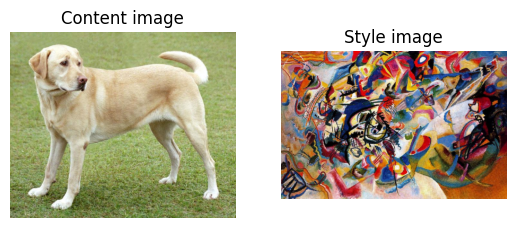

In [12]:
plt.subplot(121)
show(content_image[0], "Content image")

plt.subplot(122)
show(style_image[0] , "Style image")

plt.show()

## Loss function

### ${Content Loss} = \frac{1}{2} \sum (F(G) - F(C))^2$

**F(G)(resp F(c)):** represents the feature maps of the generated image (resp content image). It's the output of a specific layer in VGG19 model

In [13]:
def content_loss(Cl , Gl):
  n = tf.cast(len(Cl),tf.float32)
  return tf.add_n([tf.reduce_mean(tf.square(u - v)) for u,v in zip(Cl,Gl)]) / n

### Gram matrix:  
# $G^l_{cd} = \frac{\sum_{ij} F^l_{ijc}(x)F^l_{ijd}(x)}{IJ}$
`l`: Represents the layer in the neural network where the feature maps are extracted.

`c` and `d`: Represent different channels (feature channels) in the feature maps.



In [14]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_coef = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_coef)

### $\text{Style Loss} = \sum_{l} (G^l(G) - G^l(S))^2$

**G(x):** represents the gram matrix obtained from the output of a specific layer in VGG19 model when applied to image x

In [15]:
def style_loss(Sl , Gl):
  l = []
  for u , v in zip(Sl , Gl):
    gen_sm = gram_matrix(u)
    style_sm = gram_matrix(v)
    l.append(tf.reduce_mean(tf.square(style_sm - gen_sm)))
  return tf.add_n(l) / tf.cast(len(Sl) , tf.float32)

In [16]:
# the function return a tuple whose the first element is the output os style layers and
# the second element is the output os content layers

def get_features(model, tensor):
  output = model(tensor)
  return {"style" : output[:number_style_layers],
          "content" : output[number_style_layers:]}

### $\text{Total Loss} = \alpha \cdot \text{Content Loss} + \beta \cdot \text{Style Loss}$

In [17]:
def total_loss(style_loss , content_loss , style_weight = 1e-2 , content_weight = 1e4):
    return style_loss * style_weight + content_loss * content_weight

In [18]:
# avoid explosif grandient
def clip(image, min_val, max_val):
  return tf.clip_by_value(image, clip_value_min=min_val, clip_value_max=max_val)

## Style Transfer

In [19]:
class StyleTransfer:

  @tf.function()
  def gradient_descent(self, model,optimizer, gen_image, style_features,
                      content_features, style_weight, content_weight):

      with tf.GradientTape() as g:
        g.watch(gen_image)
        gen_image_sfeatures , gen_image_cfeatures = get_features(model, gen_image).values()
        j_content = content_loss(content_features , gen_image_cfeatures)
        j_style = style_loss(style_features , gen_image_sfeatures)
        j_total = total_loss(j_style , j_content, style_weight, content_weight)

      norm_means = np.array([103.939, 116.779, 123.68])
      min_vals = -norm_means
      max_vals = 255 - norm_means
      grad = g.gradient(j_total , gen_image)
      optimizer.apply_gradients([(grad, gen_image)])
      gen_image.assign(clip(gen_image, min_vals, max_vals))
      return j_total, j_style, j_content

  def __call__(self, model, style_path, content_path, learning_rate, style_weight, content_weight, epochs):

      history = {"content_loss":[], "style_loss":[], "total_loss":[]}
      style_image = img_preprocess(style_path)
      content_image = img_preprocess(content_path)

      # getting content and style features
      style_features = get_features(model, style_image)["style"]
      content_features = get_features(model, content_image)["content"]

      # adding some noise to the content_image
      content_img_shape = tf.shape(content_image)
      noise = tf.random.uniform(content_img_shape, minval=0, maxval=0.5)
      gen_image = tf.add(content_image, noise)
      gen_image = tf.Variable(gen_image, tf.float32)
      # changing the gen_image
      opt = tf.keras.optimizers.Adam(learning_rate, beta_1=0.99, epsilon=1e-8)
      for i in range(epochs):
          all_losses = self.gradient_descent(model,
                                        opt,
                                        gen_image,
                                        style_features,
                                        content_features,
                                        style_weight,
                                        content_weight)

          history["total_loss"].append(all_losses[0].numpy())
          history["style_loss"].append(all_losses[1].numpy())
          history["content_loss"].append(all_losses[2].numpy())

          if i % 100 == 0:
              img = PIL.Image.fromarray(deprocess_img(gen_image.numpy()))
              display.clear_output(wait=True)
              display.display_png(img)
              print(f"epoch: {i}\ntotal_loss: {all_losses[0]}")

      return history


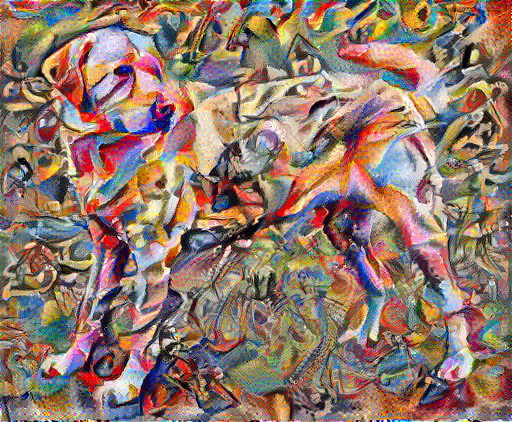

epoch: 3000
total_loss: 142753328.0


In [20]:
arguments_dict = { "model" : transfer_model,
        "style_path" : "Vassily_Kandinsky,_1913_-_Composition_7.jpg",
        "content_path" : "YellowLabradorLooking_new.jpg",
        "learning_rate" : 5,
        "style_weight" : 10,
        "content_weight" : 1e3,
        "epochs" : 3001}

transfer1 = StyleTransfer()
history = transfer1(**arguments_dict)

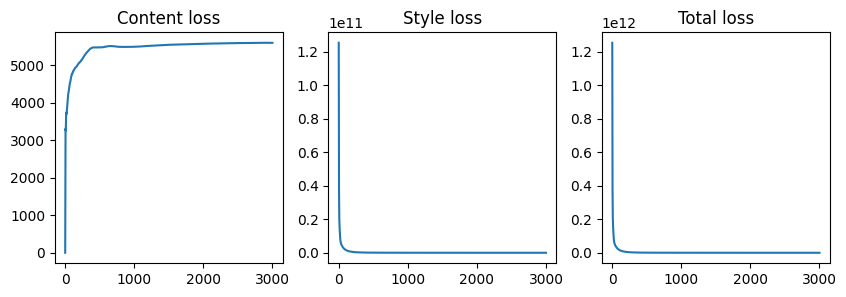

In [21]:
plt.figure(figsize = (10,3))

plt.subplot(1,3,1)
plt.plot(history["content_loss"])
plt.title("Content loss")

plt.subplot(1,3,2)
plt.plot(history["style_loss"])
plt.title("Style loss")

plt.subplot(1,3,3)
plt.plot(history["total_loss"])
plt.title("Total loss")

plt.show()

### Example 2

In [22]:
!wget https://www.planetegrandesecoles.com/wp-content/uploads/2023/02/estimation-nuit-etoilee-tableau-van-gogh-850x560.jpg
!wget https://nt.global.ssl.fastly.net/binaries/content/gallery/website/national/regions/wales/places/powis-castle-and-garden/library/castle-terraces-view-powis-castle-wales-1047435.jpg

--2023-09-29 16:43:34--  https://www.planetegrandesecoles.com/wp-content/uploads/2023/02/estimation-nuit-etoilee-tableau-van-gogh-850x560.jpg
Resolving www.planetegrandesecoles.com (www.planetegrandesecoles.com)... 141.94.139.58
Connecting to www.planetegrandesecoles.com (www.planetegrandesecoles.com)|141.94.139.58|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168148 (164K) [image/jpeg]
Saving to: ‘estimation-nuit-etoilee-tableau-van-gogh-850x560.jpg’

estimation-nuit-eto 100%[===================>] 164.21K  --.-KB/s    in 0.05s   

2023-09-29 16:43:34 (2.93 MB/s) - ‘estimation-nuit-etoilee-tableau-van-gogh-850x560.jpg’ saved [168148/168148]

--2023-09-29 16:43:34--  https://nt.global.ssl.fastly.net/binaries/content/gallery/website/national/regions/wales/places/powis-castle-and-garden/library/castle-terraces-view-powis-castle-wales-1047435.jpg
Resolving nt.global.ssl.fastly.net (nt.global.ssl.fastly.net)... 151.101.1.194, 151.101.65.194, 151.101.129.194, ...


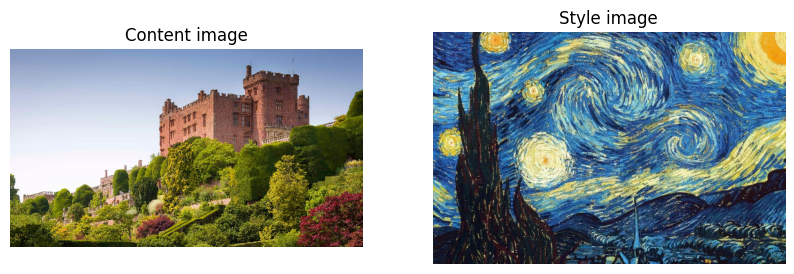

In [23]:
plt.figure(figsize = (10,5))

content_image2 = load_image("castle-terraces-view-powis-castle-wales-1047435.jpg")
style_image2 = load_image("estimation-nuit-etoilee-tableau-van-gogh-850x560.jpg")


plt.subplot(121)
show(content_image2[0], "Content image")

plt.subplot(122)
show(style_image2[0] , "Style image")

plt.show()

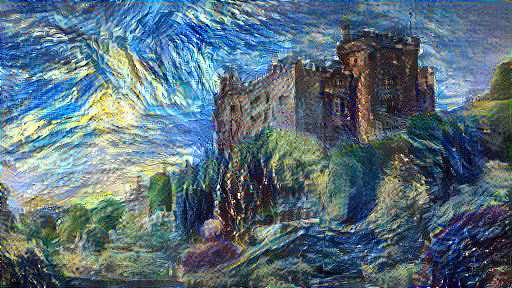

epoch: 3000
total_loss: 3160185.25


In [24]:
arguments_dict = { "model" : transfer_model,
        "style_path" : "estimation-nuit-etoilee-tableau-van-gogh-850x560.jpg",
        "content_path" : "castle-terraces-view-powis-castle-wales-1047435.jpg",
        "learning_rate" : 5,
        "style_weight" : 1e-2,
        "content_weight" : 1e4,
        "epochs" : 3001}

transfer2 = StyleTransfer()
history = transfer2(**arguments_dict)

### Example 3

In [25]:
!wget https://www.artisangallery.fr/4411/tableau-roses-pansies-and-other-flowers-in-a-vase-oil-on-canvas-.jpg
!wget https://www.parcanimalierlabarben.com/wp-content/uploads/2014/10/lynx-07082020-1.jpg

--2023-09-29 16:44:27--  https://www.artisangallery.fr/4411/tableau-roses-pansies-and-other-flowers-in-a-vase-oil-on-canvas-.jpg
Resolving www.artisangallery.fr (www.artisangallery.fr)... 217.148.138.63
Connecting to www.artisangallery.fr (www.artisangallery.fr)|217.148.138.63|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75675 (74K) [image/jpeg]
Saving to: ‘tableau-roses-pansies-and-other-flowers-in-a-vase-oil-on-canvas-.jpg’

tableau-roses-pansi 100%[===================>]  73.90K  --.-KB/s    in 0.08s   

2023-09-29 16:44:27 (950 KB/s) - ‘tableau-roses-pansies-and-other-flowers-in-a-vase-oil-on-canvas-.jpg’ saved [75675/75675]

--2023-09-29 16:44:27--  https://www.parcanimalierlabarben.com/wp-content/uploads/2014/10/lynx-07082020-1.jpg
Resolving www.parcanimalierlabarben.com (www.parcanimalierlabarben.com)... 104.21.86.226, 172.67.137.107, 2a06:98c1:3121::, ...
Connecting to www.parcanimalierlabarben.com (www.parcanimalierlabarben.com)|104.21.86.226|:443..

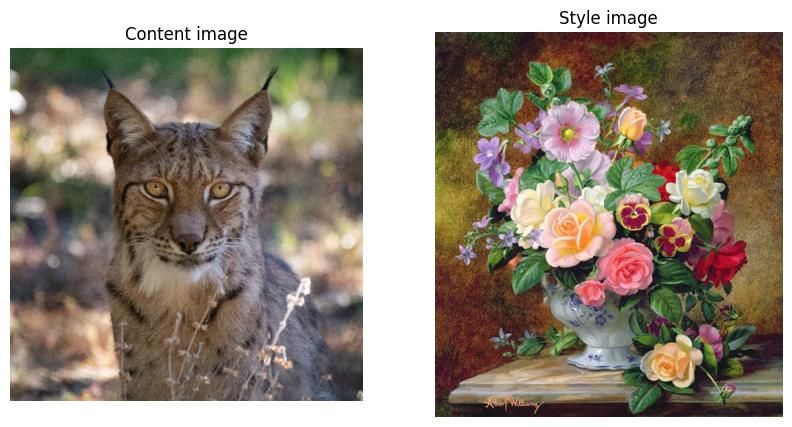

In [26]:
content_image3 = load_image("lynx-07082020-1.jpg")
style_image3 = load_image("tableau-roses-pansies-and-other-flowers-in-a-vase-oil-on-canvas-.jpg")

plt.figure(figsize = (10,5))
plt.subplot(121)
show(content_image3[0], "Content image")

plt.subplot(122)
show(style_image3[0] , "Style image")

plt.show()

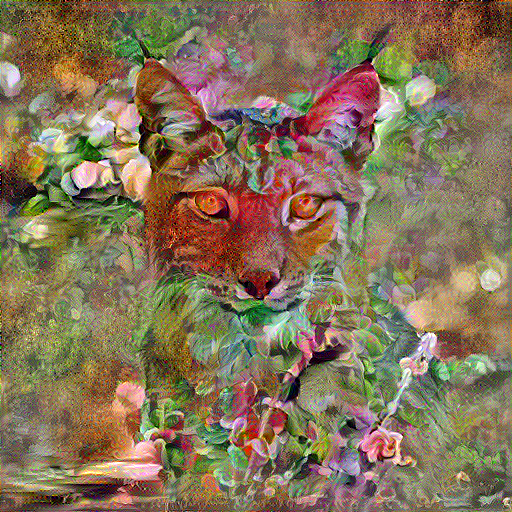

epoch: 1000
total_loss: 5702996.0


In [27]:
arguments_dict = { "model" : transfer_model,
        "style_path" : "tableau-roses-pansies-and-other-flowers-in-a-vase-oil-on-canvas-.jpg",
        "content_path" : "lynx-07082020-1.jpg",
        "learning_rate": 10,
        "style_weight" : 1e-1,
        "content_weight" : 1e4,
        "epochs" : 1001}

transfer3 = StyleTransfer()
history = transfer3(**arguments_dict)

### Example 4

In [28]:
!wget https://cdn.topofart.com/images/artists/Edvard-Munch/paintings-wm/munch004.jpg
!wget https://thedailyapologist.com/images/featured/_1553x874_crop_center-center_80_none/AdobeStock_317104103.jpeg

--2023-09-29 16:44:57--  https://cdn.topofart.com/images/artists/Edvard-Munch/paintings-wm/munch004.jpg
Resolving cdn.topofart.com (cdn.topofart.com)... 185.172.149.128, 2a0b:4d07:201::1
Connecting to cdn.topofart.com (cdn.topofart.com)|185.172.149.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64195 (63K) [image/jpeg]
Saving to: ‘munch004.jpg’

munch004.jpg        100%[===================>]  62.69K  --.-KB/s    in 0.1s    

2023-09-29 16:44:58 (520 KB/s) - ‘munch004.jpg’ saved [64195/64195]

--2023-09-29 16:44:58--  https://thedailyapologist.com/images/featured/_1553x874_crop_center-center_80_none/AdobeStock_317104103.jpeg
Resolving thedailyapologist.com (thedailyapologist.com)... 172.67.188.54, 104.21.64.247, 2606:4700:3036::ac43:bc36, ...
Connecting to thedailyapologist.com (thedailyapologist.com)|172.67.188.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 117049 (114K) [image/jpeg]
Saving to: ‘AdobeStock_317104103.jpeg’

Ad

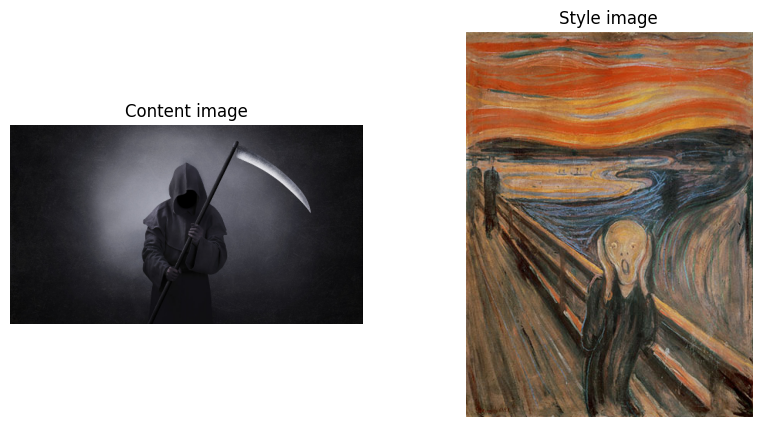

In [29]:
content_image3 = load_image("AdobeStock_317104103.jpeg")
style_image3 = load_image("munch004.jpg")

plt.figure(figsize = (10,5))
plt.subplot(121)
show(content_image3[0], "Content image")

plt.subplot(122)
show(style_image3[0] , "Style image")

plt.show()

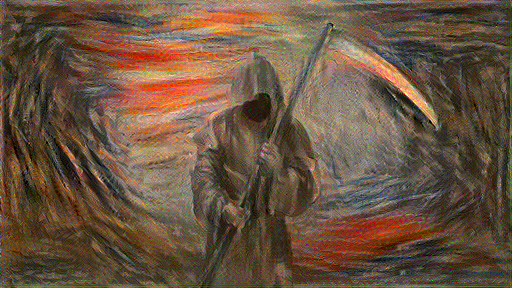

epoch: 1000
total_loss: 2846043.25


In [30]:
arguments_dict = { "model" : transfer_model,
        "style_path" : "munch004.jpg",
        "content_path" : "AdobeStock_317104103.jpeg",
        "learning_rate": 5,
        "style_weight" : 1e-1,
        "content_weight" : 1e4,
        "epochs" : 1001}

transfer4 = StyleTransfer()
history = transfer4(**arguments_dict)